In [73]:
import pathlib
from datetime import datetime, timedelta
import argparse
import warnings
import logging

import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
import tobac

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
start_date = datetime(2025,7,4)
end_date = datetime(2025,7,11)

In [3]:
data_path = pathlib.Path(f"/scratch/b/b382728/tobac_precip_features/")

In [4]:
feature_files = []
for date in pd.date_range(start_date, end_date, freq="D", inclusive="left").to_pydatetime():
    feature_files.extend(
        list(
            (data_path / f'{date.year}' / f'{date.month:02d}' / f'{date.day:02d}')
            .glob("tobac_*_feature_mask_file.nc")
        )
    )

feature_files = sorted(feature_files)

In [5]:
len(feature_files)

168

In [56]:
feature_files[0]

PosixPath('/scratch/b/b382728/tobac_precip_features/2025/07/04/tobac_20250704-000000_20250704-010000_ICON_feature_mask_file.nc')

In [14]:
rename_vars = {
    "time_feature":"time" ,
    "y":"hdim_1",
    "x":"hdim_2",
}

combined_features = tobac.utils.combine_feature_dataframes(
    [
        xr.open_dataset(f).drop_vars("all_feature_labels").drop_dims(["time","lat","lon"]).rename(rename_vars).to_dataframe().reset_index()
        for f in feature_files
    ], 
    old_feature_column_name = "label"
)


In [15]:
combined_features

,feature,frame,idx,hdim_1,hdim_2,detection_pixel_count,threshold_value,time,timestr,latitude,longitude,segmentation_pixel_count,min_BT,mean_BT,mean_OLR,min_OLR,area,max_precip,total_precip,label
0,1,0,67,164.821424,339.988520,18,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,73.467858,34.048852,14,240.409531,240.563553,162.598892,162.297531,4.877787e+08,0.526407,1.763538e+08,25
1,2,0,95,185.604312,333.757110,12,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,71.389569,33.425711,6,238.789841,240.150803,161.797653,159.147614,2.371773e+08,0.599836,1.387364e+08,37
2,3,0,133,203.447076,3069.815208,11,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,69.605292,307.031521,29,239.235733,240.009018,161.517456,160.011795,1.242102e+09,0.588835,4.652247e+08,49
3,4,0,188,218.778650,286.186927,17,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,68.072135,28.668693,82,237.407852,239.569931,160.666580,156.483902,3.729756e+09,1.319259,7.917596e+08,56
4,5,0,277,247.163605,655.041983,13,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,65.233639,65.554198,73,230.812881,236.355682,154.526611,144.080399,3.787119e+09,0.737289,1.058434e+09,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289892,1289893,671,14268,1458.749853,2022.386512,8,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-55.924985,202.288651,42,230.670959,236.462433,154.731415,143.819183,2.914238e+09,7.042422,9.689047e+09,17513
1289893,1289894,671,14270,1482.000000,2052.496362,2,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-58.250000,205.299636,299,224.706757,233.793839,149.732147,133.060287,1.957188e+10,6.601695,2.553219e+10,17514
1289894,1289895,671,14271,1496.453715,2063.032930,9,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-59.695372,206.353293,277,220.332489,230.600464,143.899933,125.446182,1.716384e+10,6.741511,1.547063e+10,17515
1289895,1289896,671,14272,1497.348936,2051.318721,3,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-59.784894,205.181872,213,220.689346,227.530258,138.271729,126.058472,1.318561e+10,6.136389,2.769421e+10,17516


In [16]:
dt = 900  # in seconds
dxy = 11100  # in meter (for Latitude)
    
parameters_tracking = dict(
    d_max=2.5*dxy,
    method_linking="predict",
    adaptive_stop=0.2,
    adaptive_step=0.95,
    stubs=1,
    memory=1,
    PBC_flag="hdim_2",
    min_h2=0,
    max_h2=3600,
)


In [17]:
tracks = tobac.linking_trackpy(
    combined_features,
    None,
    dt,
    dxy,
    **parameters_tracking,
)

Frame 671: 1833 trajectories present.


In [18]:
tracks

,feature,frame,idx,hdim_1,hdim_2,detection_pixel_count,threshold_value,time,timestr,latitude,...,min_BT,mean_BT,mean_OLR,min_OLR,area,max_precip,total_precip,label,cell,time_cell
0,1,0,67,164.821424,339.988520,18,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,73.467858,...,240.409531,240.563553,162.598892,162.297531,4.877787e+08,0.526407,1.763538e+08,25,1,0 days 00:00:00
1,2,0,95,185.604312,333.757110,12,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,71.389569,...,238.789841,240.150803,161.797653,159.147614,2.371773e+08,0.599836,1.387364e+08,37,2,0 days 00:00:00
2,3,0,133,203.447076,3069.815208,11,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,69.605292,...,239.235733,240.009018,161.517456,160.011795,1.242102e+09,0.588835,4.652247e+08,49,3,0 days 00:00:00
3,4,0,188,218.778650,286.186927,17,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,68.072135,...,237.407852,239.569931,160.666580,156.483902,3.729756e+09,1.319259,7.917596e+08,56,4,0 days 00:00:00
4,5,0,277,247.163605,655.041983,13,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,65.233639,...,230.812881,236.355682,154.526611,144.080399,3.787119e+09,0.737289,1.058434e+09,69,5,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289892,1289893,671,14268,1458.749853,2022.386512,8,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-55.924985,...,230.670959,236.462433,154.731415,143.819183,2.914238e+09,7.042422,9.689047e+09,17513,233156,0 days 02:30:00
1289893,1289894,671,14270,1482.000000,2052.496362,2,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-58.250000,...,224.706757,233.793839,149.732147,133.060287,1.957188e+10,6.601695,2.553219e+10,17514,235093,0 days 01:00:00
1289894,1289895,671,14271,1496.453715,2063.032930,9,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-59.695372,...,220.332489,230.600464,143.899933,125.446182,1.716384e+10,6.741511,1.547063e+10,17515,236134,0 days 00:15:00
1289895,1289896,671,14272,1497.348936,2051.318721,3,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-59.784894,...,220.689346,227.530258,138.271729,126.058472,1.318561e+10,6.136389,2.769421e+10,17516,236135,0 days 00:15:00


In [19]:
parameters_merge = dict(
    distance=dxy*10, frame_len=1, PBC_flag="hdim_2", min_h1=0, max_h1=1800, min_h2=0, max_h2=3600,
)

In [20]:
merges = tobac.merge_split.merge_split_MEST(tracks, dxy, **parameters_merge)

In [21]:
merges

<xarray.Dataset> Size: 39MB
Dimensions:                   (cell: 236472, feature: 1289897, track: 130976)
Coordinates:
  * cell                      (cell) int64 2MB 1 2 3 4 ... 236470 236471 236472
  * feature                   (feature) int64 10MB 1 2 3 ... 1289896 1289897
  * track                     (track) int64 1MB 1 2 3 4 ... 130974 130975 130976
Data variables:
    cell_parent_track_id      (cell) int64 2MB 1 2 3 4 ... 128479 130976 126733
    feature_parent_cell_id    (feature) int64 10MB 1 2 3 ... 236135 234486
    feature_parent_track_id   (feature) int64 10MB 1 2 3 ... 126740 130044
    track_child_cell_count    (track) int64 1MB 1 1 1 1 1 2 1 ... 1 1 1 1 1 1 1
    cell_child_feature_count  (cell) int64 2MB 4 1 1 19 1 1 2 ... 1 1 1 1 1 1 1
    cell_starts_with_split    (cell) bool 236kB False False False ... False True
    cell_ends_with_merge      (cell) bool 236kB False False ... False False

In [27]:
merges.feature_parent_track_id.to_pandas()

feature
1               1
2               2
3               3
4               4
5               5
            ...  
1289893    129307
1289894    130340
1289895    126740
1289896    126740
1289897    130044
Name: feature_parent_track_id, Length: 1289897, dtype: int64

In [30]:
tracks = tracks.set_index("feature")

In [31]:
tracks["track"] = merges.feature_parent_track_id.to_pandas()

In [32]:
tracks

,frame,idx,hdim_1,hdim_2,detection_pixel_count,threshold_value,time,timestr,latitude,longitude,...,mean_BT,mean_OLR,min_OLR,area,max_precip,total_precip,label,cell,time_cell,track
feature,,,,,,,,,,,,,,,,,,,,,
1,0,67,164.821424,339.988520,18,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,73.467858,34.048852,...,240.563553,162.598892,162.297531,4.877787e+08,0.526407,1.763538e+08,25,1,0 days 00:00:00,1
2,0,95,185.604312,333.757110,12,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,71.389569,33.425711,...,240.150803,161.797653,159.147614,2.371773e+08,0.599836,1.387364e+08,37,2,0 days 00:00:00,2
3,0,133,203.447076,3069.815208,11,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,69.605292,307.031521,...,240.009018,161.517456,160.011795,1.242102e+09,0.588835,4.652247e+08,49,3,0 days 00:00:00,3
4,0,188,218.778650,286.186927,17,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,68.072135,28.668693,...,239.569931,160.666580,156.483902,3.729756e+09,1.319259,7.917596e+08,56,4,0 days 00:00:00,4
5,0,277,247.163605,655.041983,13,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,65.233639,65.554198,...,236.355682,154.526611,144.080399,3.787119e+09,0.737289,1.058434e+09,69,5,0 days 00:00:00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289893,671,14268,1458.749853,2022.386512,8,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-55.924985,202.288651,...,236.462433,154.731415,143.819183,2.914238e+09,7.042422,9.689047e+09,17513,233156,0 days 02:30:00,129307
1289894,671,14270,1482.000000,2052.496362,2,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-58.250000,205.299636,...,233.793839,149.732147,133.060287,1.957188e+10,6.601695,2.553219e+10,17514,235093,0 days 01:00:00,130340
1289895,671,14271,1496.453715,2063.032930,9,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-59.695372,206.353293,...,230.600464,143.899933,125.446182,1.716384e+10,6.741511,1.547063e+10,17515,236134,0 days 00:15:00,126740


In [35]:
# Criteria: track max precip >= 5, track min BT <=225, track total lifetime >=30 minutes
gp_track = tracks.groupby("track")
track_max_precip = gp_track.max_precip.max()
track_min_bt = gp_track.min_BT.min()
track_start_time = gp_track.time.min()
track_end_time = gp_track.time.max()
track_lifetime = track_end_time - track_start_time

track_is_valid = (track_max_precip>=5) & (track_min_bt<=225) & (track_lifetime>=np.timedelta64(30, "m"))

In [41]:
track_lifetime

track
1        0 days 00:45:00
2        0 days 00:00:00
3        0 days 00:00:00
4        0 days 04:30:00
5        0 days 00:00:00
               ...      
130972   0 days 00:00:00
130973   0 days 00:00:00
130974   0 days 00:00:00
130975   0 days 00:00:00
130976   0 days 00:00:00
Name: time, Length: 130976, dtype: timedelta64[ns]

In [38]:
track_max_precip>=5

track
1         False
2         False
3         False
4         False
5         False
          ...  
130972    False
130973     True
130974     True
130975    False
130976     True
Name: max_precip, Length: 130976, dtype: bool

In [39]:
track_min_bt<=225

track
1         False
2         False
3         False
4         False
5         False
          ...  
130972    False
130973     True
130974    False
130975    False
130976    False
Name: min_BT, Length: 130976, dtype: bool

In [42]:
track_lifetime>=np.timedelta64(30, "m")

track
1          True
2         False
3         False
4          True
5         False
          ...  
130972    False
130973    False
130974    False
130975    False
130976    False
Name: time, Length: 130976, dtype: bool

In [37]:
track_is_valid

track
1         False
2         False
3         False
4         False
5         False
          ...  
130972    False
130973    False
130974    False
130975    False
130976    False
Length: 130976, dtype: bool

In [45]:
track_is_valid.index[track_is_valid]

Index([    12,     21,     24,     27,     29,     33,     36,     37,     38,
           40,
       ...
       130710, 130715, 130716, 130718, 130720, 130721, 130722, 130725, 130726,
       130735],
      dtype='int64', name='track', length=55502)

In [47]:
tracks = tracks[np.isin(tracks.track, track_is_valid.index[track_is_valid])]

In [49]:
tracks["time_track"] = tracks.time - tracks.groupby("track").time.min()[tracks.track].to_numpy()

/tmp/ipykernel_2668305/3817457383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks["time_track"] = tracks.time - tracks.groupby("track").time.min()[tracks.track].to_numpy()


In [50]:
tracks

,frame,idx,hdim_1,hdim_2,detection_pixel_count,threshold_value,time,timestr,latitude,longitude,...,mean_OLR,min_OLR,area,max_precip,total_precip,label,cell,time_cell,track,time_track
feature,,,,,,,,,,,,,,,,,,,,,
12,0,519,336.746106,2446.124389,19,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,56.275389,244.662439,...,135.094147,127.502312,2.182438e+09,2.913926e+00,9.145179e+08,99,12,0 days 00:00:00,12,0 days 00:00:00
22,0,929,510.316570,2463.049971,13,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,38.918343,246.354997,...,148.349869,127.804314,1.947321e+10,4.150551e+00,1.611115e+09,128,22,0 days 00:00:00,21,0 days 00:00:00
25,0,1139,558.530467,1284.583807,11,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,34.096953,128.508381,...,140.227386,123.837006,2.296166e+10,7.695796e-01,2.654245e+09,135,25,0 days 00:00:00,24,0 days 00:00:00
28,0,1257,580.344878,1467.703806,11,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,31.915512,146.820381,...,159.535843,159.535843,1.049101e+08,2.245733e-13,2.356001e-05,138,28,0 days 00:00:00,27,0 days 00:00:00
30,0,1583,637.846257,781.209577,21,0.5,2025-07-04 00:00:00,2025-07-04 00:00:00,26.165374,78.170958,...,143.953812,124.468178,2.868849e+10,1.001655e+00,1.637831e+09,140,30,0 days 00:00:00,29,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289889,671,14262,1414.165982,2209.200133,17,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-51.466598,220.970013,...,148.453079,136.058746,5.005124e+09,1.106887e+01,1.613293e+10,17509,233464,0 days 02:15:00,129472,0 days 02:15:00
1289890,671,14263,1415.802454,1624.032360,6,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-51.630245,162.453236,...,140.180603,127.008026,3.983958e+09,8.779263e+00,8.924074e+09,17510,226776,0 days 07:00:00,125869,0 days 07:00:00
1289894,671,14270,1482.000000,2052.496362,2,5.0,2025-07-10 23:45:00,2025-07-10 23:45:00,-58.250000,205.299636,...,149.732147,133.060287,1.957188e+10,6.601695e+00,2.553219e+10,17514,235093,0 days 01:00:00,130340,0 days 01:00:00


In [ ]:
xr.Dataset.from_pa

In [52]:
times = np.unique(tracks.time)

In [53]:
times[0]

numpy.datetime64('2025-07-04T00:00:00.000000000')

In [55]:
t = datetime.fromisoformat(str(times[0]))

In [59]:
label_ds = xr.open_dataset(
    list(
        (data_path / f'{t.year}' / f'{t.month:02d}' / f'{t.day:02d}').glob(f'tobac_{t.strftime("%Y%m%d-%H%M%S")}*_feature_mask_file.nc')
    )[0]
).all_feature_labels

In [60]:
label_ds

<xarray.DataArray 'all_feature_labels' (time: 4, lat: 1800, lon: 3600)> Size: 104MB
[25920000 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 32B 2025-07-04 ... 2025-07-04T00:45:00
  * lat      (lat) float64 14kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float64 29kB 0.05 0.15 0.25 0.35 ... 359.7 359.8 359.9 360.0

In [61]:
tracks_t = tracks[tracks.time==t]

In [62]:
tracks_t

,frame,idx,hdim_1,hdim_2,detection_pixel_count,threshold_value,time,timestr,latitude,longitude,...,mean_OLR,min_OLR,area,max_precip,total_precip,label,cell,time_cell,track,time_track
feature,,,,,,,,,,,,,,,,,,,,,
12,0,519,336.746106,2446.124389,19,0.5,2025-07-04,2025-07-04 00:00:00,56.275389,244.662439,...,135.094147,127.502312,2.182438e+09,2.913926e+00,9.145179e+08,99,12,0 days,12,0 days
22,0,929,510.316570,2463.049971,13,0.5,2025-07-04,2025-07-04 00:00:00,38.918343,246.354997,...,148.349869,127.804314,1.947321e+10,4.150551e+00,1.611115e+09,128,22,0 days,21,0 days
25,0,1139,558.530467,1284.583807,11,0.5,2025-07-04,2025-07-04 00:00:00,34.096953,128.508381,...,140.227386,123.837006,2.296166e+10,7.695796e-01,2.654245e+09,135,25,0 days,24,0 days
28,0,1257,580.344878,1467.703806,11,0.5,2025-07-04,2025-07-04 00:00:00,31.915512,146.820381,...,159.535843,159.535843,1.049101e+08,2.245733e-13,2.356001e-05,138,28,0 days,27,0 days
30,0,1583,637.846257,781.209577,21,0.5,2025-07-04,2025-07-04 00:00:00,26.165374,78.170958,...,143.953812,124.468178,2.868849e+10,1.001655e+00,1.637831e+09,140,30,0 days,29,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874,0,14874,1440.000000,777.020697,3,5.0,2025-07-04,2025-07-04 00:00:00,-54.050000,77.752070,...,145.946915,128.439606,1.278891e+11,1.544296e+01,1.022499e+11,4375,1874,0 days,1370,0 days
1875,0,14875,1441.100255,1574.423247,10,5.0,2025-07-04,2025-07-04 00:00:00,-54.160025,157.492325,...,147.368256,133.040497,1.700191e+10,6.059828e+00,1.961856e+10,4376,1875,0 days,1371,0 days
1876,0,14876,1440.371215,3135.992800,8,5.0,2025-07-04,2025-07-04 00:00:00,-54.087122,313.649280,...,142.651108,130.131912,1.416016e+10,6.265744e+00,2.393380e+10,4377,1876,0 days,1369,0 days


In [64]:
label_map = np.zeros(label_ds.max().item()+1)
label_map[tracks_t.label] = tracks_t.track

In [66]:
label_map[label_ds]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

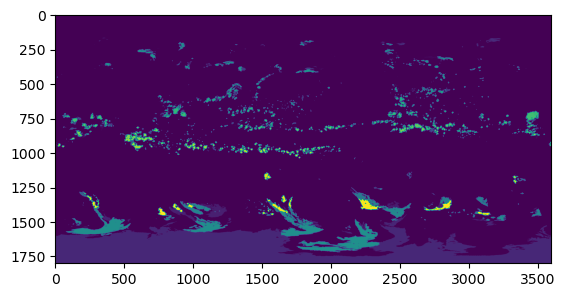

In [70]:
plt.imshow(label_ds.sel(time=t))

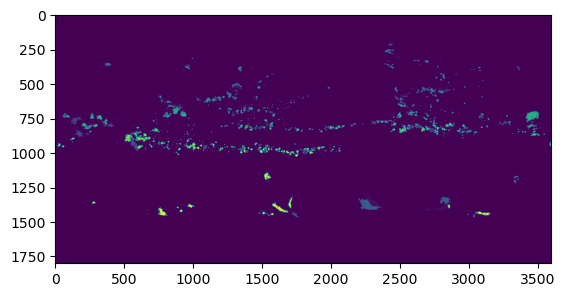

In [71]:
plt.imshow(label_map[label_ds.sel(time=t)])

In [72]:
max_track_label = tracks_t.track.max()

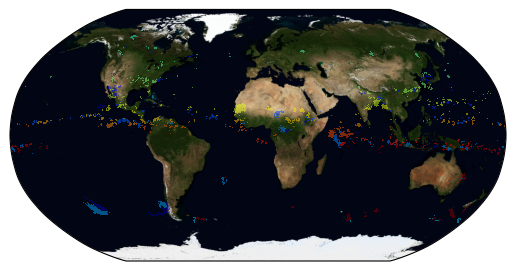

In [78]:
fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.Robinson()))

ax.imshow(
    plt.imread("/home/b/b382728/data/world.200407.3x5400x2700.jpg"),
    extent=[-180,180,-90,90], transform=ccrs.PlateCarree()
)

ax.imshow(
    ma.array(label_map[label_ds.sel(time=t)], mask=label_map[label_ds.sel(time=t)]==0), 
    cmap="jet", vmin=1, vmax=max_track_label, interpolation="nearest", 
    extent=[0,360,-90,90], transform=ccrs.PlateCarree(), alpha=0.5
)

In [80]:
import intake
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
dataset = cat.ICON.ngc4008(chunks="auto", time="PT15M", zoom=9).to_dask()

/home/b/b382728/miniconda3/envs/tobac/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [82]:
import healpy
pix = xr.DataArray(
    healpy.ang2pix(dataset.crs.healpix_nside, *np.meshgrid(label_ds.lon, label_ds.lat), nest=True, lonlat=True),
    coords=(label_ds.lat, label_ds.lon),
)

In [83]:
olr = dataset.rlut.sel(time=t, cell=pix)

In [86]:
from matplotlib.colors import ListedColormap
alpha_cmap = np.ones([256,4])
alpha_cmap[:,-1] = np.linspace(0,1,256)
alpha_cmap = ListedColormap(alpha_cmap)

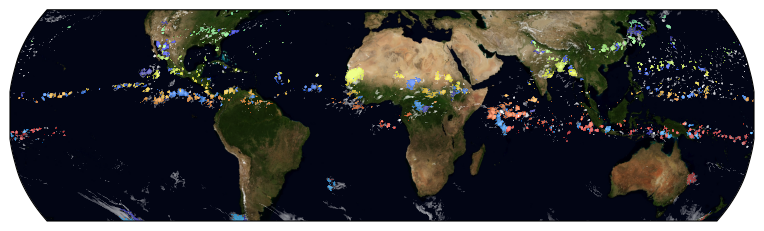

In [110]:
fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.Robinson()), figsize=(9.6,4.8))

ax.imshow(
    plt.imread("/home/b/b382728/data/world.200407.3x5400x2700.jpg"),
    extent=[-180,180,-90,90], transform=ccrs.PlateCarree()
)

ax.imshow(
    -olr, cmap=alpha_cmap, vmin=-200, vmax=-100, 
    extent=[0,360,-90,90], transform=ccrs.PlateCarree()
)

ax.imshow(
    ma.array(label_map[label_ds.sel(time=t)], mask=label_map[label_ds.sel(time=t)]==0), 
    cmap="jet", vmin=1, vmax=max_track_label, interpolation="nearest", 
    extent=[0,360,-90,90], transform=ccrs.PlateCarree(), alpha=0.5
)

ax.set_extent([-180,180,-45,45], crs=ccrs.PlateCarree())

In [120]:
viridis_alpha = plt.cm.viridis(np.linspace(0,1,256))
viridis_alpha[...,-1] = np.linspace(0,1,256)**0.125
viridis_alpha = ListedColormap(viridis_alpha)

In [122]:
pr = dataset.pr.sel(time=t, cell=pix) * 3.6e3

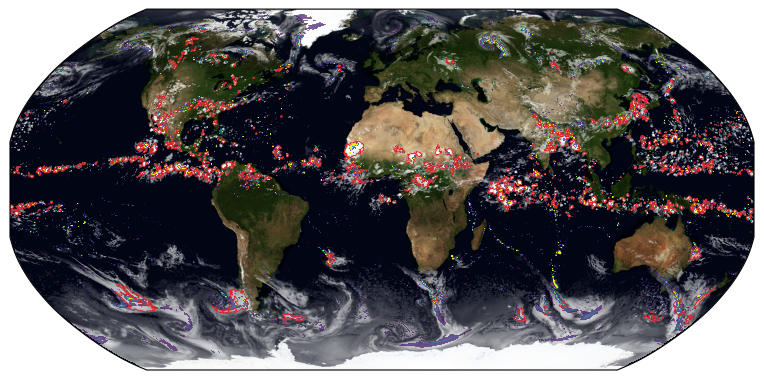

In [124]:
fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.Robinson()), figsize=(9.6,4.8))

ax.imshow(
    plt.imread("/home/b/b382728/data/world.200407.3x5400x2700.jpg"),
    extent=[-180,180,-90,90], transform=ccrs.PlateCarree()
)

ax.imshow(
    -olr, cmap=alpha_cmap, vmin=-250, vmax=-100, 
    extent=[0,360,-90,90], transform=ccrs.PlateCarree()
)

ax.imshow(
    pr, cmap=viridis_alpha, vmin=0.5, vmax=5, 
    extent=[0,360,-90,90], transform=ccrs.PlateCarree()
)

ax.contour(
    *np.meshgrid(label_ds.lon, label_ds.lat),label_map[label_ds.sel(time=t)]>0, 
    [0.5], colors=["C03"], linewidths=[0.5], 
    transform=ccrs.PlateCarree()
)

ax.set_extent([-180,180,-80,80], crs=ccrs.PlateCarree())

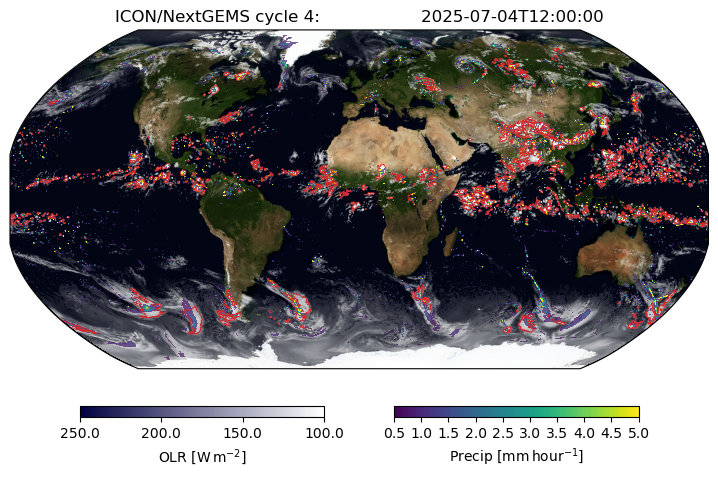

In [190]:
t = datetime.fromisoformat(str(times[48]))
tracks_t = tracks[tracks.time==t]

label_ds = xr.open_dataset(
    list(
        (data_path / f'{t.year}' / f'{t.month:02d}' / f'{t.day:02d}').glob(f'tobac_{t.strftime("%Y%m%d-%H%M%S")}*_feature_mask_file.nc')
    )[0]
).all_feature_labels

fig, ax = plt.subplots(subplot_kw = dict(projection=ccrs.Robinson()), figsize=(9.6,4.4))

ax.imshow(
    plt.imread("/home/b/b382728/data/world.200407.3x5400x2700.jpg"),
    extent=[-180,180,-90,90], transform=ccrs.PlateCarree()
)

ax.imshow(
    -dataset.rlut.sel(time=t, cell=pix), cmap=alpha_cmap, vmin=-250, vmax=-100, 
    extent=[0,360,-90,90], transform=ccrs.PlateCarree()
)

ax.imshow(
    dataset.pr.sel(time=t, cell=pix) * 3.6e3, cmap=viridis_alpha, vmin=0.5, vmax=5, 
    extent=[0,360,-90,90], transform=ccrs.PlateCarree()
)

ax.contour(
    *np.meshgrid(label_ds.lon, label_ds.lat), np.isin(label_ds.sel(time=t), tracks_t.label), 
    [0.5], colors=["C03"], linewidths=[0.5], 
    transform=ccrs.PlateCarree()
)

ax.set_extent([-180,180,-80,80], crs=ccrs.PlateCarree())

ax.set_title(f'                    ICON/NextGEMS cycle 4:', loc="left")
ax.set_title(f'{t.isoformat()}                    ', loc="right")

ax_position = ax.get_position().bounds
# ax_width = ax_position[2] - ax_position[0]

from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Rectangle
cax = fig.add_axes([ax_position[0] + ax_position[2]*0.1, 0, ax_position[2]*0.35, 0.025])
cbar_cmap = np.ones([256,4])
cbar_cmap[:,0] = np.linspace(0,1,256)
cbar_cmap[:,1] = np.linspace(0,1,256)
cbar_cmap[:,2] = np.linspace(0.25,1,256)
cbar_cmap = ListedColormap(cbar_cmap)
cbar = ColorbarBase(cax, cmap=cbar_cmap, orientation = 'horizontal')
cbar.set_ticks(np.linspace(0,1,4), labels=np.linspace(250,100,4))
cbar.set_label(r"OLR [$\mathrm{W\,m^{-2}}$]")

cax = fig.add_axes([ax_position[0] + ax_position[2]*0.55, 0, ax_position[2]*0.35, 0.025])
cax.set_facecolor([0.2,0,0,1])
cbar = ColorbarBase(cax, cmap=viridis_alpha, orientation = 'horizontal')
cbar.set_ticks(np.linspace(0,1,10), labels=np.linspace(0.5,5,10))
cbar.set_label(r"Precip [$\mathrm{mm\,hour^{-1}}$]")


In [189]:
ax.get_position().bounds

(0.14873209432098855, 0.10999999999999999, 0.7275358113580229, 0.77)

In [133]:
fig, axes = plt.subplots(1, 3, subplot_kw = dict(projection=ccrs.PlateCarree()), figsize=(9.6,4.8))



In [128]:
np.isin(label_ds.sel(time=t), tracks_t.label).shape

(1800, 3600)

In [ ]:
feature_labels = xr.concat(
    [xr.open_dataset(f).all_feature_labels for f in feature_files], 
    "time"
)

In [ ]:
feature_labels